# Интерполяция функций, аппроксимация функций

## Интерполяция

Подмодуль [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate) содержит в себе методы для интерполяции.

Коротко про интерполяцию можно почитать в [википедии](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BF%D0%BE%D0%BB%D1%8F%D1%86%D0%B8%D1%8F). Более подробное изложение можно найти в {cite}`Samarsky`.

> Задача интерполирования состоит в том, чтобы по значениям функции $f(x)$ в нескольких точках отрезка восстановить ее значения в остальных точках этого отрезка. Разумеется, такая задача допускает сколь угодно много решений. Задача интерполирования возникает, например, в том случае, когда известны результаты измерения $y_h= f(x, k)$ некоторой физической величины $f(x)$ в точках $x_k, k = 0, 1, ..., n$, и требуется определить ее значения в других точках. Интерполирование используется также при сгущении таблиц, когда вычисление значений $f(x)$ трудоемко. Иногда возникает необходимость приближенной замены или аппроксимации данной функции другими функциями, которые легче вычислить. В частности, рассматривается задача о наилучшем приближении в нормированном пространстве $H$, когда заданную функцию $f\in H$ требуется заменить линейной комбинацией $\phi$ заданных элементов из $H$ так, чтобы отклонение $||f—\phi||$ было минимальным. Результаты и методы теории интерполирования и приближения функций нашли широкое применение в численном анализе, например при выводе формул численного дифференцирования и интегрирования, при построении сеточных аналогов задач математической физики {cite}`Samarsky`.

Для того чтобы рассмотреть интерполяцию, сгенерируем данные. Т.е. сгенерируем массив узлов интерполяционной сетки `x_data` и значений `y_data` некоторой функции $f$ в узлах этой сетки.

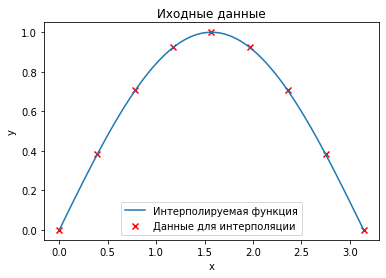

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

L = 0
R = np.pi
n_points = 10 # при 63 уже ломается 
f = np.sin


def plot_problem(ax, x_data, y_data):
    ax.scatter(x_data, y_data, marker="x", color="red")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    

x_data = np.linspace(L, R, n_points - 1) # данные для интерполяции
y_data = f(x_data)                       # данные для интерполяции


x = np.linspace(L, R, 100)    # данные для построения графика
y = f(x)                      # данные для построения графика

fig, ax = plt.subplots()
ax.plot(x, y)
plot_problem(ax, x_data, y_data)
ax.set_title("Исходные данные")
ax.legend(["Интерполируемая функция", "Данные для интерполяции"])
plt.show()

Теперь когда данные готовы, осталось произвести интерполяцию. Методов интерполяции существует очень много. Рассмотрим полиномиальную интерполяцию и сплайн интерполяцию.

### Полиномиальная интерполяция

Полиномиальная интерполяция основывается на том факте, что существует единственный полином $P_{N}(x) = a_0 + a_1 x + \cdots + a_{N} x ^ N $ степени $N$, проходящий через точки $\{(x_1, y_1), ..., (x_{N + 1}, y_{N + 1})\}$, если $x_i \neq x_j \quad \forall i, j = 1, \cdots, N + 1, \quad i \neq j$.  

Недостатком полиномиальной интерполяции является её нестабильность. Полиномиальная интерполяция проявляет себя очень плохо при больших $N$. 

Text(0.5, 1.0, 'Интерполяция')

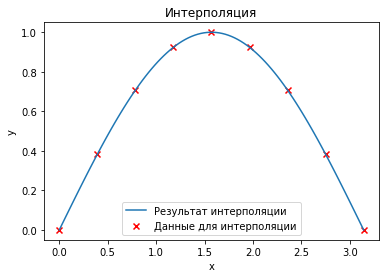

In [76]:
from scipy import interpolate

poly = interpolate.KroghInterpolator(x_data, y_data)
y_poly = poly(x)

fig, ax = plt.subplots()
ax.plot(x, y_poly)
plot_problem(ax, x_data, y_data)
ax.legend(["Полиномиальная интерполяция", "Данные для интерполяции"])
ax.set_title("Интерполяция")

### Сплайн интерполяция

> Интерполирование многочленом ... на всем отрезке $[a, b]$ с использованием большого числа узлов интерполяции часто приводит к плохому приближению, что объясняется сильным накоплением погрешностей в процессе вычислений. Кроме того, из-за расходимости процесса интерполяции увеличение числа узлов не обязано приводить к повышению точности. Для того чтобы избежать больших погрешностей, весь отрезок $[a, b]$ разбивают на частичные отрезки и на каждом из частичных отрезков приближенно заменяют функцию $f(х)$ многочленом невысокой степени (так называемая кусочно-полиномиальная интерполяция). Одним из способов интерполирования на всем отрезке является интерполирование с помощью сплайн-функций. Сплайн-функцией или сплайном называют кусочно-полиномиальную функцию, определенную на отрезке $[a, b]$ и имеющую на этом отрезке некоторое число непрерывных производных {cite}`Samarsky`.  


Text(0.5, 1.0, 'Интерполяция')

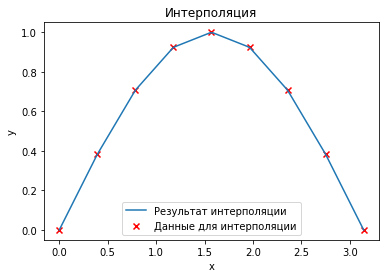

In [77]:
linear = interpolate.interp1d(x_data, y_data, kind="linear")
y_linear = linear(x)

fig, ax = plt.subplots()
ax.plot(x, y_linear)
plot_problem(ax, x_data, y_data)
ax.legend(["Кусочно-линейная интерполяция", "Данные для интерполяции"])
ax.set_title("Интерполяция")

Text(0.5, 1.0, 'Интерполяция')

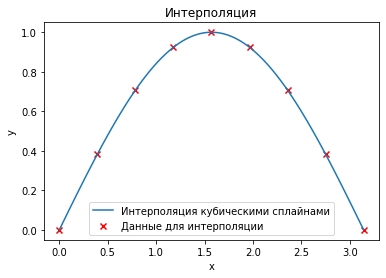

In [80]:
cubic = interpolate.interp1d(x_data, y_data, kind="cubic")
y_cubic = cubic(x)

fig, ax = plt.subplots()
ax.plot(x, y_cubic)
plot_problem(ax, x_data, y_data)
ax.legend(["Интерполяция кубическими сплайнами", "Данные для интерполяции"])
ax.set_title("Интерполяция")

## Аппроксимация функций

Задача аппроксимации функции очень похожа на задачу интерполирования, но в интерполировании обычно ставится целью поиск такой функции $\phi$, которая в точности проходит через известные нам точки $(x_i, y_i)$, где $y_i = f(x_i), i = 1, ..., N$, а при аппроксимации допускается отклонение функции $\phi$ от этих точек. 

В ряде ситуаций, значение исходной функции $f$ в точках $x_i, i=1,...,N$ может быть известно не точно, а в пределах какой-то погрешности или с точностью до какой-то случайной величины, т.е., например, $y_i = f(x_i) + \varepsilon_i, \, i = 1, ..., N$. В таком случае такое строгое требование на то, чтобы наше решение $\phi(x)$ в точности проходило через все точки $(x_i, y_i), i=1, ..., N$ не имеет большого смысла и может быть ослаблено, например, до поиска такой функции $\phi$ из определенного класса функций, которая меньше всего отклоняется от значений $(x_i, y_i), i=1,..., n$.  

Пусть, аппроксимирующая функция дана в параметризованном виде и задача аппроксимации ставится следующим образом:

$$
    \sum_{i=1}^{N}||\phi_p(x_i) - y_i||^2 \sim \min_{p\in D}.
$$

Иными словами требуется найти такие параметры $p$, что функция $\phi_p(x)$ наименее всего отклоняется от точек $(x_i, y_i), i=1, ..., N$ в среднеквадратичном смысле. 


```{note}
В общем случае, и $x_i$, $y_i$ и $p$ --- здесь векирные величины.
```

При такой постановке часто выделяют линейную и нелинейную аппроксимации. Аппроксимация является линейной, если $\phi_p(x)$ линейно зависит от параметров $p$, не линейной в ином случае. 


```{note}
Аппроксимация функций реализована во множестве других библиотек, таких как [statsmodels](https://www.statsmodels.org/stable/index.html), [scikit-learn](https://scikit-learn.org/stable/) и некоторых других. 
```

### Линейная аппроксимация

Разберем в качестве примера полиномиальную аппроксимацию. Для начала сгенерируем данные.

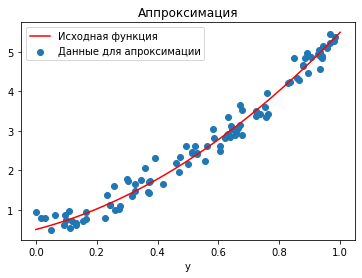

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def f(x):
    return 0.5 + 2 * x + 3 * x * x

def plot_problem(ax, x_true, y_true, x_data, y_data):
    ax.scatter(x_data, y_data)
    ax.plot(x_true, y_true, 'r')
    ax.set_xlabel("x")
    ax.set_xlabel("y")
    ax.set_title("Аппроксимация")



N = 100
sigma = 0.2
x_data = np.random.uniform(low=0, high=1, size=N)
y_data = f(x_data) + np.random.normal(loc=0, scale=sigma, size=N)

x = np.linspace(0, 1, 100) # чтобы строить график
y = f(x)                   # чтобы строить график


fig, ax = plt.subplots()
plot_problem(ax, x, y, x_data, y_data)
ax.legend(["Исходная функция", "Данные для апроксимации",])

В ячейке выше, мы сгенерировали массив `x_data` случайных значений в интервале $[0, 1]$. На основе него и функции `f` мы сгенерировали массив `y_data`, который представляют из себя сумму значений функции `f` в точках с координатами `x_data` и случайного шума, распределенного по Гауссу с нулевым средним и дисперсией `sigma`. 

На графике мы построили набор получившихся точек и исходную функцию `f`. Теперь попробуем приблизить её линейной функцией $\phi_1(x) = \alpha_1 + \beta_1 x$ методом наименьших квадратов, т.е. мы хотим решить задачу минимизации невязки `R`, где невязка для заданных параметров $\alpha_1$ и  $\beta_1$ задаётся суммой квадратов отклонений функции $\phi_1(x)$ в точках $x_i$ от $y_i$: 

$$
R_1 = \sum_{i=1}^{N}  (\phi_1(x_i) - y_i) ^ 2 = \sum_{i=1}^{N} (\alpha_1 + \beta_1 x_i - y_i) ^ 2 \sim \min_{\alpha_1, \beta_1},
$$

где $x_i$ соответствует `x_data[i]`, а $y_i$ соответствует `y_data[i]`.

Решить эту задачу можно методом [scipy.linalg.lstsq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html#scipy.linalg.lstsq). Он позволяет найти такой $x$, который минимизирует невязку СЛАУ $A x = b$ методом наименьших квадратов, т.е. $x = \text{argmin}_{x\in\mathbb{R}^2} || A x- b|| ^ 2$. В нашей задаче этот $x$ представляет собой вектор параметров $\alpha_1$ и $\beta_1$. Нам необходимо составить матрицу $A$ и вектор $b$ таким образом, чтобы невязка $|| A x - b || ^ 2$ для заданного вектора $x = \begin{pmatrix} \alpha_1 \\ \beta_1 \end{pmatrix}$ совпадала с $R_1$.  Для этого составим матрицу $A$ следующего вида:

$$
A = \begin{pmatrix}
1 & x_0 \\
1 & x_1 \\
\vdots & \vdots \\
1 & x_n
\end{pmatrix},
$$
а в качестве вектора $b$ возьмем наш массив `y_data` и заметим, что невязка уравнения

$$
\begin{pmatrix}
1 & x_0 \\
1 & x_1 \\
\vdots & \vdots \\
1 & x_n
\end{pmatrix} \begin{pmatrix}
\alpha_1 \\ \beta_1
\end{pmatrix} = \begin{pmatrix} y_0 \\ y_1 \\ \vdots \\ y_n
\end{pmatrix}
$$ 

совпадает с искомой минимизируемой величиной $R_1$.

0.0036541526156261706 5.057467746802313


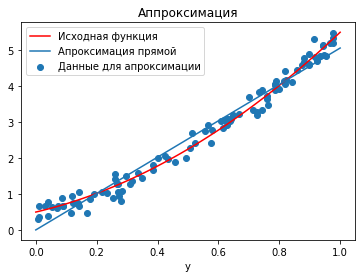

In [21]:
from scipy import linalg

A = x_data[:, np.newaxis] ** [0, 1]
b = y_data

sol, _, _, _ = linalg.lstsq(A, b)
alpha_1, beta_1 = sol
y_approx = alpha_1 + beta_1 * x
print(alpha_1, beta_1)


fig, ax = plt.subplots()
plot_problem(ax, x, y, x_data, y_data)
ax.plot(x, y_approx)
ax.legend(["Исходная функция", "Аппроксимация прямой", "Данные для аппроксимации"])

Как видно, аппроксимирующая функция подстроилась под набор точек, но не идеально. Это связано с тем, что мы искали решение в классе линейных функций, а искомая функция имеет квадратичное слагаемое. Расширим класс наших функций. Будем искать решение в виде функции $\phi_2(x) = \alpha_2 + \beta_2 x + \gamma_2 x^2$. 

Соответствующая СЛАУ с нужной нам невязкой будет иметь вид:

$$
\begin{pmatrix}
1 & x_0 & x_0 ^ 2\\
1 & x_1 & x_1 ^ 2\\
\vdots & \vdots & \vdots \\
1 & x_n & x_n^2
\end{pmatrix} \begin{pmatrix}
\alpha_2 \\ \beta_2 \\ \gamma_2
\end{pmatrix} = \begin{pmatrix} y_0 \\ y_1 \\ \vdots \\ y_n
\end{pmatrix}.
$$ 

0.4254345494947798 2.3228917501598714 2.7353265065738697


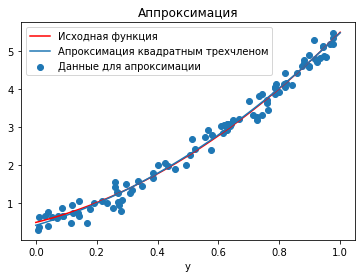

In [22]:
A = x_data[:, np.newaxis] ** [0, 1, 2]
b = y_data

sol, _, _, _ = linalg.lstsq(A, b)
alpha_2, beta_2, gamma_2 = sol
y_approx = alpha_2 + beta_2 * x + gamma_2 * x * x
print(alpha_2, beta_2, gamma_2)

fig, ax = plt.subplots()
plot_problem(ax, x, y, x_data, y_data)
ax.plot(x, y_approx)
ax.legend(["Исходная функция", "Аппроксимация квадратным трехчленом", "Данные для аппроксимации"])

Квадратный трехчлен гораздо ближе проходит к исходной функции. 

Вообще говоря, таким способом можно искать решение в виде линейной комбинации любых функций $\varphi(x) = c_1\varphi_1(x) + \cdots + c_k\varphi_k(x)$. Соответствующая матрица $A$ будет иметь вид

$$
A = \begin{pmatrix}
\varphi_1(x_1) &\cdots & \varphi_k(x_1) \\
\vdots & \ddots & \vdots \\
\varphi_1(x_N) &\cdots & \varphi_k(x_N)
\end{pmatrix}.
$$

А конкретно для полиномиальных функций существует функция [np.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html). 


```{note}
Все вышерассмотренные случаи представляют собой линейную аппроксимацию, т.к. аппроксимирующая функция линейно зависила от подбираемых параметров (коэффициентов).
```

### Нелинейная аппроксимация

Сгенерируем данные для нелинейной аппроксимации.

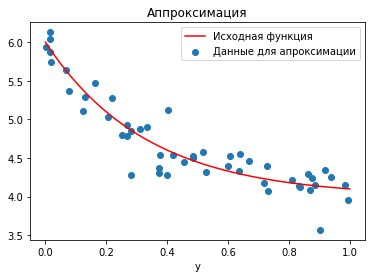

In [27]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def f(x):
    return 2*np.exp(-3*x) + 4

def plot_problem(ax, x_true, y_true, x_data, y_data):
    ax.scatter(x_data, y_data)
    ax.plot(x_true, y_true, 'r')
    ax.set_xlabel("x")
    ax.set_xlabel("y")
    ax.set_title("Аппроксимация")



N = 50
sigma = 0.2
x_data = np.random.uniform(low=0, high=1, size=N)
y_data = f(x_data) + np.random.normal(loc=0, scale=sigma, size=N)

x = np.linspace(0, 1, 100) # чтобы строить график
y = f(x)                   # чтобы строить график


fig, ax = plt.subplots()
plot_problem(ax, x, y, x_data, y_data)
ax.legend(["Исходная функция", "Данные для апроксимации",])

Будем искать нашу функцию в виде

$$
\phi_{\alpha, \beta, \gamma}(x) = \alpha e^{\beta x} + \gamma,
$$

и попробуем восстановить значения параметров $\alpha, \beta$ и $\gamma$ из сгенерированных данных. Аппроксимация не линейна, т.к. $\phi$ нелинейно зависит от параметра $\beta$. Метод [optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) позволяет искать приближенное решение задачи нелинейной аппроксимации.

Чтобы воспользоваться этим методом, необходимо определить функцию, которая первым своим аргументом принимает $x$ (может быть скаляром, а может быть и вектором), а остальными аргументами принимает параметры $p$. В примере ниже это функция `f_approx`.


Найденные параметры: 
alpha: 1.928,
beta: -3.292,
gamma: 4.060



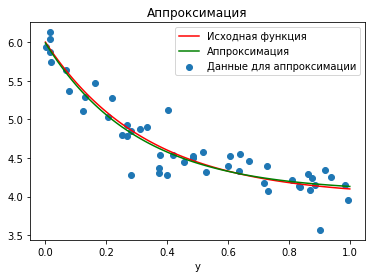

In [28]:
from scipy import optimize

def f_approx(x, alpha, beta, gamma):
    return alpha * np.exp(beta * x) + gamma

p, _ = optimize.curve_fit(f_approx, x_data, y_data, p0=[3, -6, 10])

y_approx = f_approx(x, *p)

fig, ax = plt.subplots()
plot_problem(ax, x, y, x_data, y_data)
ax.plot(x, y_approx, color="g")
ax.legend(["Исходная функция", "Аппроксимация", "Данные для аппроксимации"])

print("""
Найденные параметры: 
alpha: {:.3f},
beta: {:.3f},
gamma: {:.3f}
""".format(*p)
)

В случае нелинейной аппроксимации следует проявлять особую осторожность, т.е. среднеквадратичное отклонение минимизируется численными методами и начальное предположение о значениях параметров $p0$ играет большую роль: при не удачном $p0$ алгоритм может сойтись не туда или вообще не сойтись. 

## Список литературы

```{bibliography}
:style: unsrt
```